In [34]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"

opencv-contrib-python              4.10.0.84
opencv-python                      4.10.0.84
opencv-python-headless             4.10.0.84
pytorch-ignite                     0.5.1
pytorch-lightning                  2.5.0.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.2.0
sentence-transformers              3.3.1
tensorflow                         2.17.1
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.7
tensorflow_decision_forests        1.10.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
tensorflow-text                    2.17.0
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchinfo                          1.8.0
torchmetrics                       1.6.1
torchsummary                       1.5.1
torchtune       

In [35]:
!rm -rf /kaggle/working/results/checkpoint-*
!rm -rf /kaggle/working/logs/*


In [36]:
!pip install torch torchvision transformers opencv-python scikit-learn

In [37]:
import pandas as pd

# Load the CSV file
csv_path = '/kaggle/input/multimodal-disaster-dataset-bangla/Multimodal Disaster Bangla Dataset/Thesis.csv'
df = pd.read_csv(csv_path,encoding="utf-8")
df.head()

,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1,কুমিল্লা,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1,কুমিল্লা,NaN
2,3,কুমিল্লা,flood,1,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1,ফেনী,NaN


In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torchvision import transforms

In [39]:
# Drop unnecessary columns if they exist
columns_to_drop = [col for col in ['label', 'area', 'Unnamed: 5'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)

# Shuffle the dataframe
df = shuffle(df, random_state=42)

In [40]:
# Split the dataset
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio / (val_ratio + test_ratio), random_state=42)


In [41]:

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# ✅ Step 1: Load XLM-R tokenizer and encode text data
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


# Load the BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base')

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Tokenize
train_encodings = tokenizer(list(train_data['caption']), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(valid_data['caption']), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_data['caption']), truncation=True, padding=True, max_length=512)

# Prepare labels
train_labels = list(train_data['level'])
val_labels = list(valid_data['level'])
test_labels = list(test_data['level'])

In [43]:
import torch


# ✅ Step 2: Custom Dataset class (unchanged)
class DisasterDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# ✅ Step 3: Create datasets
train_dataset = DisasterDataset(train_encodings, train_labels)
val_dataset = DisasterDataset(val_encodings, val_labels)
test_dataset = DisasterDataset(test_encodings, test_labels)

# ✅ Step 4: Load XLM-R model
model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=2)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
from transformers import Trainer, TrainingArguments, AutoModelForSequenceClassification
from datasets import DatasetDict  # Assuming you are using Hugging Face Datasets

# ✅ Step 5: Set training arguments
training_args = TrainingArguments(
    output_dir='/kaggle/working/results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    logging_strategy="epoch",
    logging_dir='/kaggle/working/logs',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    report_to="none",
    save_safetensors=False
)

# ✅ Step 6: Trainer setup
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# ✅ Step 7: Train!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.317400,0.085256
2,0.122700,0.052061
3,0.075400,0.044098
4,0.045000,0.046183
5,0.037200,0.039731
6,0.027600,0.049000
7,0.008500,0.043428
8,0.015100,0.046490
9,0.013400,0.043804
10,0.011400,0.041631


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=1040, training_loss=0.06737606370678315, metrics={'train_runtime': 872.3216, 'train_samples_per_second': 18.927, 'train_steps_per_second': 1.192, 'total_flos': 2341667837152800.0, 'train_loss': 0.06737606370678315, 'epoch': 10.0})

In [45]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def evaluate_model(trainer, eval_dataset):
    predictions, labels, _ = trainer.predict(eval_dataset)
    
    # Convert logits to predicted classes
    preds = torch.argmax(torch.tensor(predictions), dim=1).numpy()
    
    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")

    # Generate classification report
    report = classification_report(labels, preds, target_names=["Non Informative", "Informative"])

    return accuracy, precision, recall, f1, report, labels, preds
# Evaluate the model on the validation dataset
test_accuracy, test_precision, test_recall, test_f1, test_report, all_labels, all_preds = evaluate_model(trainer, val_dataset)

# Print out the results
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print("Classification Report:\n", test_report)

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Accuracy: 0.9946
Test Precision: 0.9946
Test Recall: 0.9946
Test F1 Score: 0.9946
Classification Report:
                  precision    recall  f1-score   support

Non Informative       1.00      0.99      0.99       206
    Informative       0.99      1.00      1.00       345

       accuracy                           0.99       551
      macro avg       0.99      0.99      0.99       551
   weighted avg       0.99      0.99      0.99       551



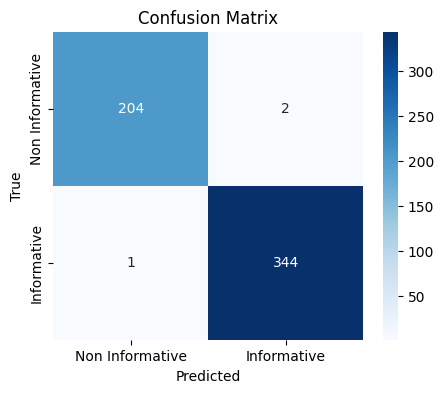

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non Informative", "Informative"], yticklabels=["Non Informative", "Informative"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()